In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std
from numpy.random import normal

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth

In [2]:
#Setup notebook so Tensorflow works in a friendly way in a shared multi GPU env

def setup_tensorflow(seed=None):
    try:
        import nvsmi
        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)

In [3]:
#If working in a multiply GPU setup run setup_tensorflow()

setup_tensorflow()

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-05-20 16:47:59.223605: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#load the image arrays, Size: (ngals, 64, 64), (2, ngals, 64, 64) respectively 

#Blends and components arrays are both noiseless

#Noise is then added to the blends which the network trains on

#Noiseless blends are used for the metrics 

components = np.load("c_isolatednew120k.npy")

In [5]:
def add_noise(img, scale=0.01):
    return img + normal(scale=scale, size=img.shape)

In [6]:
def asinh_scale(x, a=0.1, inverse=False):
    # This is a common way of scaling astronomical images
    # so that inner and outer regions of galaxies can be seen
    return np.arcsinh(x / a) / np.arcsinh(1 / a)

In [7]:
#Thresholding the masked areaas 


components[components<0] = -1*components[components<0]

components[components<22.3] = 22.3



In [8]:
#Scale the components 

components = asinh_scale(components)

#Then make the blends

blends = components[0] + components[1]

In [9]:
blends.shape, components.shape

((120000, 64, 64), (2, 120000, 64, 64))

In [10]:
np.mean(blends), np.mean(components)

(5.445390903568617, 2.72269545178434)

In [11]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [12]:
"""
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse_loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','mse_loss','val_loss','kl_loss'])
"""

"\ndef loss_plot(history):\n    plt.plot(history.history['loss'])\n    plt.plot(history.history['mse_loss'])\n    plt.plot(history.history['val_loss'])\n    plt.plot(history.history['kl_loss'])\n    plt.title('model loss')\n    plt.ylabel('loss')\n    plt.xlabel('epoch')\n    plt.legend(['loss','mse_loss','val_loss','kl_loss'])\n"

In [13]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [14]:
height,width=64,64

#train_buffer=60000
#test_buffer=10000

#batch_size=10
#latent_dimensions=16

num=4000
comps=2

beta=0.1

In [15]:
#Split into training and test set 

#Going to split training and test 80% and 20% respectively 

train_ngals = int(blends.shape[0] * 0.8)
test_ngals = int(blends.shape[0] * 0.2)

train_blends = blends[:train_ngals]
test_blends = blends[train_ngals:]

a, b, c, d, test_components = np.split(components, 5, axis = 1)

train_components = np.concatenate((a, b, c, d), axis = 1)

In [16]:
#Add noise to the training blends 

#Note we have split them up before encase later on we would like to change if our train / test blends have noise

train_blends = add_noise(train_blends)
test_blends = add_noise(test_blends)

In [17]:
#Now normalise based on maximum value of the arrays

norm_max = np.max([ np.max(train_blends), np.max(test_blends), np.max(train_components), np.max(test_components)])

train_blends /= norm_max
test_blends /= norm_max
train_components /= norm_max
test_components /= norm_max

In [18]:
train_components.shape, test_components.shape

((2, 96000, 64, 64), (2, 24000, 64, 64))

In [19]:
train_blends.shape, test_blends.shape

((96000, 64, 64), (24000, 64, 64))

In [20]:
np.amax(train_blends), np.amin(train_blends), np.amax(test_blends), np.amin(test_blends)

(1.0, 0.36271432924621233, 0.9710288975941341, 0.36289654318065895)

In [21]:
height,width=64,64

train_blends = train_blends.reshape(train_ngals, height, width, 1).astype('float32')
train_components = train_components.reshape(2, train_ngals, height, width, 1).astype('float32')

test_blends = test_blends.reshape(test_ngals, height, width, 1).astype('float32')
test_components = test_components.reshape(2, test_ngals, height, width, 1).astype('float32')

In [22]:
batch_size = 32
latent_dimensions = 32

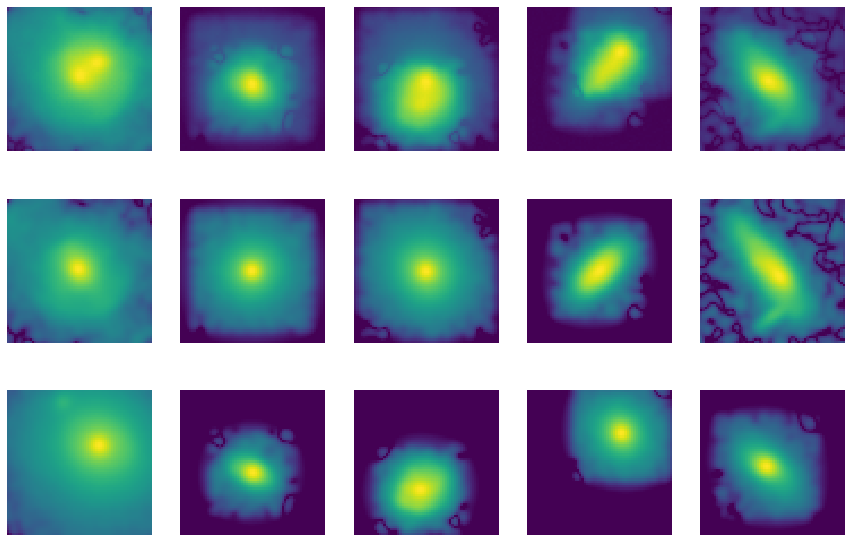

In [34]:
fig, ax = plt.subplots(train_components.shape[0] + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], origin='lower', interpolation='nearest')
    ax[0, i].axis('off')
    ax[1, i].imshow(train_components[0, i], origin='lower', interpolation='nearest')
    ax[1, i].axis('off')
    ax[2, i].imshow(train_components[1, i], origin='lower', interpolation='nearest')
    ax[2, i].axis('off')

In [35]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [36]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [37]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [38]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [39]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d_2[0][0]']               
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)    0           ['conv2d_3[0][0]']               
                                                                                            

In [40]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 model_3 (Functional)        (None, 32)                281024    
                                                                 
 model_4 (Functional)        (None, 64, 64, 1)         190849    
                                                                 
Total params: 471,873
Trainable params: 471,873
Non-trainable params: 0
_________________________________________________________________


In [41]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [42]:
val_split_ratio = 0.2
print(val_split_ratio * train_ngals)

19200.0


In [43]:
history=vae.fit(train_components[0],verbose=1,epochs=100,batch_size=batch_size,validation_split=val_split_ratio)

Epoch 1/100
2400/2400 [==============================] - 26s 11ms/step - loss: 2.1731 - mse_loss: 1.9897 - kl_loss: 0.1834 - val_loss: 0.9090 - val_mse_loss: 0.7410 - val_kl_loss: 0.1679
Epoch 2/100
2400/2400 [==============================] - 26s 11ms/step - loss: 0.7707 - mse_loss: 0.6179 - kl_loss: 0.1529 - val_loss: 0.6434 - val_mse_loss: 0.5022 - val_kl_loss: 0.1412
Epoch 3/100
2400/2400 [==============================] - 25s 11ms/step - loss: 0.5976 - mse_loss: 0.4599 - kl_loss: 0.1377 - val_loss: 0.5403 - val_mse_loss: 0.4063 - val_kl_loss: 0.1340
Epoch 4/100
2400/2400 [==============================] - 26s 11ms/step - loss: 0.5165 - mse_loss: 0.3814 - kl_loss: 0.1351 - val_loss: 0.4729 - val_mse_loss: 0.3391 - val_kl_loss: 0.1338
Epoch 5/100
2400/2400 [==============================] - 25s 11ms/step - loss: 0.4614 - mse_loss: 0.3272 - kl_loss: 0.1342 - val_loss: 0.4371 - val_mse_loss: 0.3013 - val_kl_loss: 0.1358
Epoch 6/100
2400/2400 [==============================] - 26s 11ms

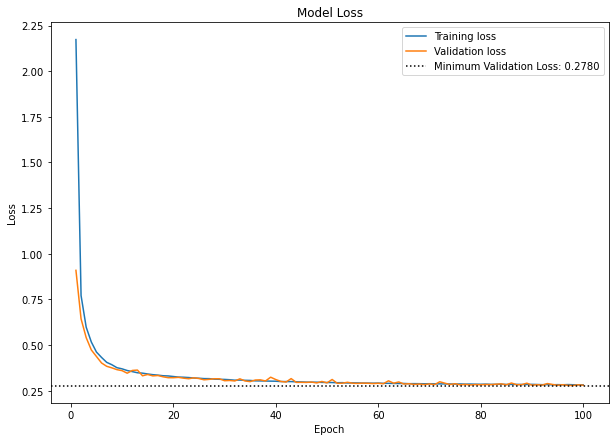

In [44]:
histplot(history)

In [69]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest')
        ax[0, i].set_title('Input Galaxy')
        ax[0, i].axis('off')
        ax[1, i].imshow(output_img[i], origin='lower', interpolation='nearest')
        ax[1, i].set_title(f'Reconstruction - SSIM: {ssim(output_img[i], input_img[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False):.2f}')
        ax[1, i].axis('off')
        ax[2, i].imshow(abs(input_img[i] - output_img[i]), origin='lower', interpolation='nearest')
        ax[2, i].set_title('Re Comp Difference')
        ax[2, i].axis('off')
        plt.tight_layout()
    return idx

In [1]:
chosen=summary_plot(n,test_components[0],decode)

NameError: name 'summary_plot' is not defined

In [47]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [48]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode=Model([input_embed,input_compc],[output1])
decode.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 64)    0           ['conv2d_5[0][0]']               
                                                                                            

In [49]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2,input_compc])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_6 (Functional)           (None, 32)           281024      ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_7 (Functional)           (None, 64, 64, 1)    190849      ['model_6[0][0]',                
                                                                  'input_6[0][0]']          

In [50]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

train_together=[train_blends,train_components[0]]

test_together = [test_blends, test_components[0], test_components[1]]
#together_v=[blended_v,components_v[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [51]:
history2=vae.fit(train_together,verbose=1,epochs=100,batch_size=batch_size,validation_split=val_split_ratio)

Epoch 1/100
2400/2400 [==============================] - 26s 11ms/step - loss: 3.1649 - mse_loss: 3.0683 - kl_loss: 0.0966 - val_loss: 2.5190 - val_mse_loss: 2.4216 - val_kl_loss: 0.0974
Epoch 2/100
2400/2400 [==============================] - 25s 10ms/step - loss: 2.4066 - mse_loss: 2.3056 - kl_loss: 0.1010 - val_loss: 2.3142 - val_mse_loss: 2.2136 - val_kl_loss: 0.1006
Epoch 3/100
2400/2400 [==============================] - 25s 10ms/step - loss: 2.2496 - mse_loss: 2.1447 - kl_loss: 0.1049 - val_loss: 2.2003 - val_mse_loss: 2.0936 - val_kl_loss: 0.1068
Epoch 4/100
2400/2400 [==============================] - 25s 10ms/step - loss: 2.1610 - mse_loss: 2.0549 - kl_loss: 0.1061 - val_loss: 2.1279 - val_mse_loss: 2.0203 - val_kl_loss: 0.1076
Epoch 5/100
2400/2400 [==============================] - 25s 10ms/step - loss: 2.0750 - mse_loss: 1.9676 - kl_loss: 0.1073 - val_loss: 2.0147 - val_mse_loss: 1.9006 - val_kl_loss: 0.1141
Epoch 6/100
2400/2400 [==============================] - 25s 10ms

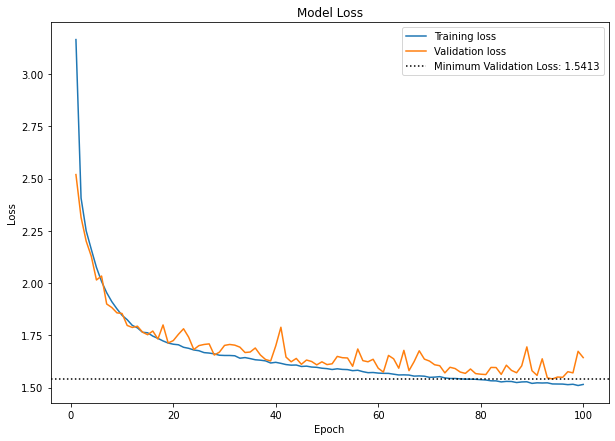

In [52]:
histplot(history2)

In [53]:
"""
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode2.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(5, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')
        showimg(input_img[i]-output_img[i], ax[4, i], f'original difference')
    return idx
"""



"\ndef summary_plot(n,inputs,decode,seed=1):\n    np.random.seed(seed)\n    #idx=np.array([0,1,2,3,4])\n    idx = np.random.choice(len(inputs[0]), size=n, replace=False)\n    print(idx)\n    input_img = inputs[0][idx]\n    compc=inputs[1][idx]\n    z = encode2.predict(input_img)\n    output_img = decode.predict([z,compc])\n    fig, ax = plt.subplots(5, n, figsize=((3)*n,15))\n    for i in range(n):\n        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'\n        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')\n        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')\n        showimg(output_img[i], ax[2, i], f'output\n{encoding}')\n        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')\n        showimg(input_img[i]-output_img[i], ax[4, i], f'original difference')\n    return idx\n"

In [54]:
def summary_plot2(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode2.predict(input_img)
    output_img = decode.predict([z,comp1])
    comp1.shape, output_img.shape
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[0, i].set_title('In Blend')
        ax[0, i].axis('off')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[1, i].set_title('In Central Comp')
        ax[1, i].axis('off')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[2, i].set_title('In Comp 2')
        ax[2, i].axis('off')
        ax[3, i].imshow(output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[3, i].set_title(f'Re Central Comp - SSIM: {ssim(output_img[i], comp1[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False):.2f}')
        ax[3, i].axis('off')
        ax[4, i].imshow(input_img[i] - output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[4, i].set_title(f'Re Residual Comp - SSIM: {ssim((input_img[i] - output_img[i]), comp2[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False):.2f}')
        ax[4, i].axis('off')
        ax[5, i].imshow(abs(comp1[i] - output_img[i]), origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[5, i].set_title('Re Comp Difference')
        ax[5, i].axis('off')
        plt.tight_layout()
    return idx

[ 6414 13523  8374  5256  4405]


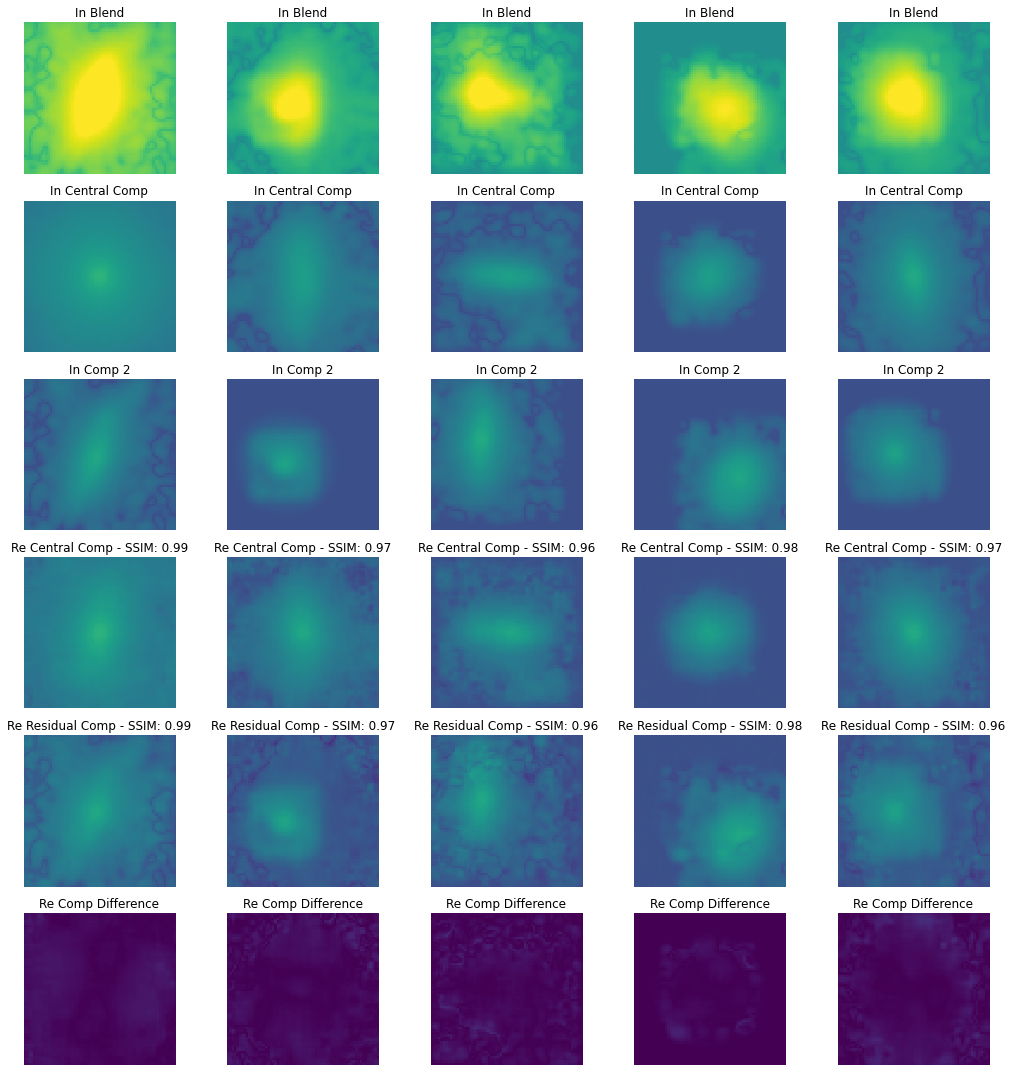

In [55]:
n = 5
chosen=summary_plot2(n,test_together,decode)

In [56]:
c = 'orangered'
outline = 'red'

(Text(0.5, 0, 'Loss'), Text(0, 0.5, 'Frequency'))

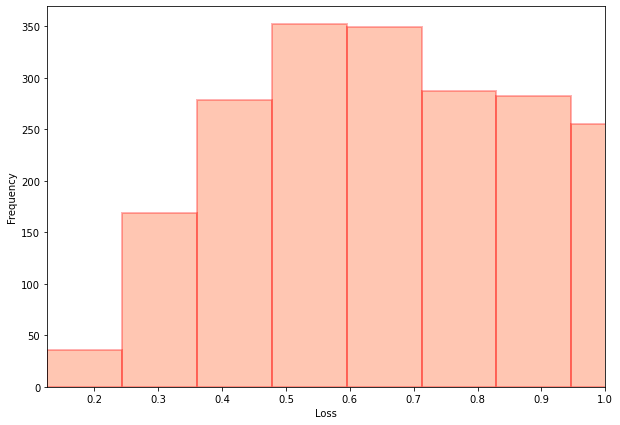

In [57]:

losses=np.zeros(num)
for ite in range(0,num):
    input_img=test_blends[ite]
    compc=test_components[0,ite]

    input_img=input_img.reshape(1,height,width,1).astype('float32')
    compc=compc.reshape(1,height,width,1).astype('float32')

    evals=vae.evaluate([input_img,compc],verbose=0,batch_size=batch_size)
    losses[ite]=evals[0]
    #print(ite)
    
loss_max=np.amax(losses)
loss_min=np.amin(losses)
ax=plt.axes()
ax.hist(losses,bins=500, color = c, ec = outline, alpha = 0.3, lw = 2 )
ax.set_xlim(max(loss_min,0),min(loss_max,1)),ax.set_ylim(0)
ax.set_xlabel("Loss"),ax.set_ylabel("Frequency")


In [58]:
#vae.save_weights("model_1.h5")
#decode.save_weights("decoder_1.h5")

In [59]:
#vae=Model.load_weights("model_1.h5")
#vae.summary()

In [60]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(test_ngals)
    ssim_comp2 = np.zeros(test_ngals)
    ssim_blends = np.zeros(test_ngals)
    input_img = inputs[0]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode2.predict(input_img)
    output_img1 = decode.predict([z, comp1])
    for i in range(test_ngals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis=2, gaussian_weights = True, use_sample_covarience = False)
        ssim_comp2[i] = ssim(comp2[i], (input_img[i] - output_img1[i]), channel_axis=2, gaussian_weights = True, use_sample_covarience = False)
 

    ssim_values = np.array([ssim_comp1, ssim_comp2])
    
    return ssim_values 

In [61]:
ssim_values = calc_ssim(test_together, decode)

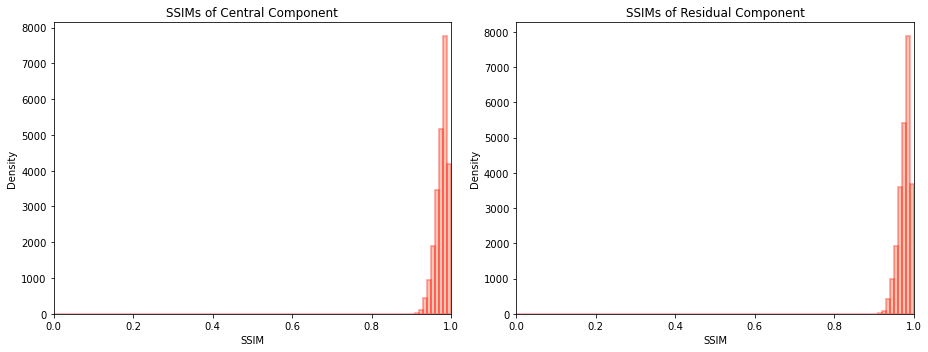

In [62]:
#Plot violinplots of the SSIM

n_of_bins = 100
bins = np.linspace(0,1,n_of_bins+1)

fig, ax = plt.subplots(1, 2, figsize = (13,5))


vp1 = ax[0].hist(ssim_values[0], bins, color = c, ec = outline, alpha = 0.3, lw = 2)

ax[0].set_title('SSIMs of Central Component')
ax[0].set_xlabel('SSIM')
ax[0].set_ylabel('Density')

 

vp2 = ax[1].hist(ssim_values[1], bins,  color = c, ec = outline, alpha = 0.3, lw = 2)

ax[1].set_title('SSIMs of Residual Component')  
ax[1].set_xlabel('SSIM')
ax[1].set_ylabel('Density')
  
ax[0].set_xlim(0, 1) 
ax[1].set_xlim(0, 1) 
plt.tight_layout()

plt.show()

In [63]:
mean_ssim_comp1 = np.mean(ssim_values[0])
median_ssim_comp1 = np.median(ssim_values[0])
mean_ssim_comp2 = np.mean(ssim_values[1])
median_ssim_comp2 = np.median(ssim_values[1])

In [64]:
print(f' Mean SSIMs: Central Component: {mean_ssim_comp1:.4f}, Residual Component: {mean_ssim_comp2:.4f}')

print(f' Median SSIMs: Central Component: {median_ssim_comp1:.4f}, Residual Component: {median_ssim_comp2:.4f} ')

 Mean SSIMs: Central Component: 0.9764, Residual Component: 0.9760
 Median SSIMs: Central Component: 0.9799, Residual Component: 0.9793 


In [65]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(test_ngals)
    
    flux_in_comp1 = np.zeros(test_ngals)
    
    flux_out_comp1 = np.zeros(test_ngals)
    
    elip_in_comp1 = np.zeros(test_ngals)
    
    elip_out_comp1 = np.zeros(test_ngals)
    
    flux_in_comp2 = np.zeros(test_ngals)
    
    flux_out_comp2 = np.zeros(test_ngals)
    
    elip_in_comp2 = np.zeros(test_ngals)

    elip_out_comp2 = np.zeros(test_ngals)
    
    input_img = inputs[0]
    input_img = input_img.reshape(test_ngals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(test_ngals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(test_ngals, height, width)
    
    z = encode2.predict(input_img)
    output_img1 = decode.predict([z, comp1])
    output_img1 = output_img1.reshape(test_ngals, height, width)
    
    for i in range(test_ngals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
            
        out_comp2_cat = photutils.morphology.data_properties(input_img[i] - output_img1[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2]   
    return parameters


        

In [66]:
parameters = calc_properties(test_together, decode)

In [71]:
np.save("real_se_parameters.npy", parameters)